##**Music-Induced Emotion Prediction: A Regression-Based Analysis of Physiological and Acoustic Data**

This Notebook presents an analysis of music-induced emotions using machine learning models. Support Vector Machine (SVM) and Random Forest (RF) regression are applied to assess their predictive capabilities. The notebook includes data preprocessing, feature engineering, exploratory analysis, model training, and evaluation for insights into personalized music therapy and adaptive recommendation systems.

**Note:** *The code cells combine library install/imports loading/saving CSV files and the functions of tasks all together to make the sections and cells run independently (if the files are saved)*

*The code in every cell manages the data well - but EDA is performed to check the stability and prevent errors.*

Mount Google as the project was done on Google Collab

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Preparing the Dataset**

####Download Audios from the Song Metadata
- Loads a CSV file (original_song_audio.csv) containing song IDs and their corresponding download links.
- Defines a function (download_file()) that downloads audio files from URLs and saves them locally.
- Iterates through the CSV, downloading each song if it is not already in the directory, ensuring no duplicates.

In [ ]:
import os
import requests
import pandas as pd

# Set Save Directory in Google Drive
save_dir = "/content/drive/My Drive/GC15_Audio/"
os.makedirs(save_dir, exist_ok=True)

# Load CSV Containing Song Links
# Update this path if the CSV is stored in a different Drive folder
csv_path = "/content/drive/My Drive/GC15_Audio/original_song_audio.csv"
df = pd.read_csv(csv_path)

# Function to Download Files
def download_file(url, save_path):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(save_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=1024):
                    file.write(chunk)
            print(f" Successfully downloaded: {save_path}")
        else:
            print(f" Failed to download: {url}")
    except Exception as e:
        print(f" Error downloading {url}: {e}")

# Download Each Song from the URL in the CSV
for index, row in df.iterrows():
    song_id = row['song_id']
    audio_url = row['link']
    save_path = os.path.join(save_dir, f"{song_id}.mp3")

    # Skip if file already exists (to avoid duplicate downloads)
    if not os.path.exists(save_path):
        download_file(audio_url, save_path)
    else:
        print(f" Skipping {song_id}, already downloaded.")

print(" All downloads complete! Check your Google Drive in 'GC15_Audio' folder.")


###Extract Audio Features
- Loads and processes MP3 files, extracting up to 1 minute of audio.
- Extracts MFCC, chroma, spectral contrast, tempo, and other spectral features using Librosa.

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import librosa.feature
from tqdm import tqdm

# Define audio file path
audio_path = "/content/drive/MyDrive/Data_Analytics_Coursework/GC15_Audios/"

# Function to extract features from up to 1 minute of the song
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=22050, mono=True)  # Load MP3 audio in mono (faster processing)

    # Check if audio is shorter than 1 minute
    required_samples = 60 * sr  # Number of samples in 1 minute
    if len(y) < required_samples:
        print(f"Warning: {file_path} is shorter than 1 minute, extracting available audio.")

    # Extract as much audio as available (max 1 minute)
    y = y[:required_samples]

    # Compute spectral features (optimized for speed)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)
    rmse = librosa.feature.rms(y=y)
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y=y)
    harm, perc = librosa.effects.hpss(y)

    # Aggregate features into a dictionary
    features = {
        'tempo': librosa.feature.tempo(y=y, sr=sr)[0],  # Fixed tempo function
        'chroma_stft_mean': np.mean(chroma_stft), 'chroma_stft_std': np.std(chroma_stft),
        'melspectrogram_mean': np.mean(melspectrogram), 'melspectrogram_std': np.std(melspectrogram),
        'mfcc_mean': np.mean(mfcc), 'mfcc_std': np.std(mfcc),
        'mfcc_delta_mean': np.mean(mfcc_delta), 'mfcc_delta_std': np.std(mfcc_delta),
        'rmse_mean': np.mean(rmse), 'rmse_std': np.std(rmse),
        'cent_mean': np.mean(cent), 'cent_std': np.std(cent),
        'spec_bw_mean': np.mean(spec_bw), 'spec_bw_std': np.std(spec_bw),
        'contrast_mean': np.mean(contrast), 'contrast_std': np.std(contrast),
        'rolloff_mean': np.mean(rolloff), 'rolloff_std': np.std(rolloff),
        'zcr_mean': np.mean(zcr), 'zcr_std': np.std(zcr),
        'harm_mean': np.mean(harm), 'harm_std': np.std(harm),
        'perc_mean': np.mean(perc), 'perc_std': np.std(perc)
    }

    return features

# Apply feature extraction (optimized tqdm settings)
features_list = []
for file in tqdm(os.listdir(audio_path), desc="Extracting Features", miniters=10):
    if file.endswith(".mp3"):  # Ensure it's an MP3 file
        song_id = os.path.splitext(file)[0]  # Remove .mp3 to get song_id
        file_path = os.path.join(audio_path, file)

        features = extract_audio_features(file_path)
        if features:  # Avoid appending None values
            features['song_id'] = song_id  # Store as song_id without .mp3
            features_list.append(features)

# Convert features to DataFrame
audio_features_df = pd.DataFrame(features_list)

# Display extracted features
print("Extracted Audio Features:\n", audio_features_df.head())

# Save as CSV for later use
dataset_path = "/content/drive/MyDrive/Data_Analytics_Coursework/HKU956/"
audio_features_df.to_csv(os.path.join(dataset_path, 'audio_features.csv'), index=False)
print("Audio features saved successfully!")


Extracting Features:   2%|▏         | 12/588 [01:18<1:02:24,  6.50s/it]

Extracting Features:  28%|██▊       | 164/588 [17:16<45:33,  6.45s/it]

Extracting Features:  30%|███       | 179/588 [18:48<41:07,  6.03s/it]

Extracting Features:  38%|███▊      | 221/588 [22:57<36:35,  5.98s/it]

Extracting Features:  39%|███▉      | 232/588 [24:06<40:41,  6.86s/it]

Extracting Features:  71%|███████   | 417/588 [42:55<16:31,  5.80s/it]

Extracting Features:  81%|████████▏ | 478/588 [49:03<11:23,  6.21s/it]

Extracting Features: 100%|██████████| 588/588 [1:00:07<00:00,  6.14s/it]


Extracted Audio Features:
         tempo  chroma_stft_mean  chroma_stft_std  melspectrogram_mean  \
0  117.453835          0.306189         0.287621             7.768965   
1  143.554688          0.334319         0.307283             3.299402   
2  151.999081          0.419633         0.305569            12.902291   
3  117.453835          0.250476         0.293616             0.494851   
4  117.453835          0.311666         0.290020             3.849729   

   melspectrogram_std  mfcc_mean   mfcc_std  mfcc_delta_mean  mfcc_delta_std  \
0           39.929188   2.691205  36.953388         0.006031        1.836954   
1           20.734159   1.849208  60.546738         0.000855        3.662044   
2           83.206917   8.098649  52.693291         0.005129        3.996112   
3            4.878867 -12.730380  86.118607        -0.001712        3.396858   
4           15.121981  -0.782892  49.597832        -0.000306        2.127184   

   rmse_mean  ...  contrast_std  rolloff_mean  rollof

###Extract and combine Physiological Features
- Iterates through participant folders, processing physiological signals (HR, BVP, EDA, TEMP) per song.
- Computes mean, median, and standard deviation for each signal type to capture key physiological variations.

In [ ]:
# Define physiological signals
physio_signals = ["HR", "BVP", "EDA", "TEMP"]

# Set path where physiological data is stored
physio_signals_path = "/content/drive/MyDrive/Data_Analytics_Coursework/HKU956/1. physiological_signals"

# List to store aggregated physiological data
physio_data_list = []

# Process each participant
print("Processing physiological data (aggregated per participant + song)...")
for participant in tqdm(os.listdir(physio_signals_path)):  # Loop through each participant
    participant_path = os.path.join(physio_signals_path, participant)

    if os.path.isdir(participant_path):  # Ensure it's a folder
        for song_file in os.listdir(os.path.join(participant_path, "HR")):  # Check HR folder for song files
            song_id = os.path.splitext(song_file)[0].split("_")[1]  # Extract song_id
            song_data = {"participant_id": participant, "song_id": song_id}

            # Process each physiological signal
            for signal in physio_signals:
                signal_path = os.path.join(participant_path, signal, song_file)

                if os.path.exists(signal_path):  # Ensure the file exists
                    try:
                        df = pd.read_csv(signal_path, header=None)  # Load signal data

                        # Compute features based on signal type
                        if signal in ["BVP", "EDA"]:
                            song_data[f"{signal}_median"] = np.median(df.iloc[:, 0])  # Use Median for BVP & EDA
                        else:
                            song_data[f"{signal}_mean"] = np.mean(df.iloc[:, 0])  # Use Mean for HR & TEMP

                        song_data[f"{signal}_std"] = np.std(df.iloc[:, 0])  # Compute standard deviation for all

                    except Exception as e:
                        print(f"Error processing {signal_path}: {e}")

            # Append processed song data for this participant
            physio_data_list.append(song_data)

# Convert to DataFrame
physio_features_df = pd.DataFrame(physio_data_list)

# Save extracted physiological features
physio_features_csv = "/content/drive/MyDrive/Data_Analytics_Coursework/HKU956/physio_features.csv"
physio_features_df.to_csv(physio_features_csv, index=False)

print(f"Physiological features saved successfully to {physio_features_csv}")


Processing physiological data (aggregated per participant + song)...


100%|██████████| 30/30 [20:49<00:00, 41.64s/it]

Physiological features saved successfully to /content/drive/MyDrive/Data_Analytics_Coursework/HKU956/physio_features.csv


### Define & load Dataset Paths

-All dataset paths are correctly defined & loaded:

- av_ratings_csv → Arousal-Valence ratings
- personality_csv → Participant personality data
- audio_features_csv → Extracted audio features
- physio_features_csv → Extracted physiological features
- No data saving included

The script only loads datasets and does not overwrite any files.


In [ ]:
import os
import pandas as pd

# Define the base dataset path (Modify based on your Google Drive structure)
dataset_path = "/content/drive/MyDrive/Data_Analytics_Coursework/HKU956"

# Define CSV file paths
av_ratings_csv = os.path.join(dataset_path, "3. AV_ratings.csv")
personality_csv = os.path.join(dataset_path, "4. participant_personality.csv")
audio_features_csv = os.path.join(dataset_path, "audio_features.csv")
physio_features_csv = os.path.join(dataset_path, "physio_features.csv")

# Load the CSV files into DataFrames
av_ratings_df = pd.read_csv(av_ratings_csv)
personality_df = pd.read_csv(personality_csv)
audio_features_df = pd.read_csv(audio_features_csv)
physio_features_df = pd.read_csv(physio_features_csv)

# Display the first few rows of each dataset
print("Arousal-Valence Ratings:\n", av_ratings_df.head(), "\n")
print("Personality Data:\n", personality_df.head(), "\n")
print("Audio Features:\n", audio_features_df.head(), "\n")
print("Physiological Features:\n", physio_features_df.head(), "\n")


Arousal-Valence Ratings:
   participant_id  song_no  song_id  valence_rating   valence  arousal_rating  \
0        hku1919       16   370177             9.3  positive             1.0   
1        hku1919        8  1119687             9.8  positive            -3.0   
2        hku1919       18    77933            -0.1  negative             1.9   
3        hku1919       14   238585             1.0  positive            -1.8   
4        hku1919       20  1168711             0.2  positive            -3.4   

    arousal  play_duration  
0  positive             72  
1  negative             73  
2  positive             41  
3  negative             66  
4  negative             33   

Personality Data:
   participant_id  Extroversion_score  Agreeableness_score  \
0        hku1903                 6.0                  4.0   
1        hku1904                 6.0                  4.0   
2        hku1905                 5.0                  5.0   
3        hku1906                 6.0                  

###Detect Missing Values in all the files

- Shows exact count of missing values per column.
- Console output listing missing values in each dataset.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all DataFrames into a dictionary for easy access
datasets = {
    "Arousal-Valence Ratings": av_ratings_df,
    "Personality Data": personality_df,
    "Audio Features": audio_features_df,
    "Physiological Features": physio_features_df
}

# Function to plot missing values count for each dataset
def plot_missing_values_bar(df, title):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]  # Filter only columns with missing values

    if not missing_values.empty:
        plt.figure(figsize=(10, 5))
        missing_values.plot(kind="bar", color="red")
        plt.title(f"Missing Values Count - {title}")
        plt.ylabel("Number of Missing Values")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"No missing values found in {title} dataset.")

# Iterate over all datasets and visualize missing values
for dataset_name, df in datasets.items():
    print(f" Checking missing values in {dataset_name} dataset:")
    print(df.isnull().sum())  # Print missing values count in console
    print("-" * 50)

    plot_missing_values_bar(df, dataset_name)  # Bar chart visualization


 Checking missing values in Arousal-Valence Ratings dataset:
participant_id    0
song_no           0
song_id           0
valence_rating    0
valence           0
arousal_rating    0
arousal           0
play_duration     0
dtype: int64
--------------------------------------------------
No missing values found in Arousal-Valence Ratings dataset.
 Checking missing values in Personality Data dataset:
participant_id               0
Extroversion_score           0
Agreeableness_score          0
Conscientiousness_score      0
Emotional_Stability_score    0
Openness_score               0
Extroversion                 0
Agreeableness                0
Conscientiousness            0
Emotional_Stability          0
Openness                     0
dtype: int64
--------------------------------------------------
No missing values found in Personality Data dataset.
 Checking missing values in Audio Features dataset:
tempo                  0
chroma_stft_mean       0
chroma_stft_std        0
melspectrogram_m

###Merge Dataset

- Aggregates AV Ratings (Mean Valence & Arousal per song_id).
- Aggregates Physiological Data (Drops participant_id, averages per song_id).
- Merges Audio Features with AV Ratings.
- Merges with Physiological Features.
- Fixes Personality Features Merging:
  - Merges personality_df with physio_features_df using participant_id to get song_id.
  - Drops participant_id, then aggregates per song_id.
  - Merges the final personality features with the dataset.
- Saves the Final Merged Dataset → merged_dataset.csv.


In [ ]:
import pandas as pd
import os

# Define dataset save path
dataset_path = "/content/drive/MyDrive/Data_Analytics_Coursework/HKU956"

# **Aggregate AV Ratings (Mean Valence & Arousal per Song)**
av_ratings_agg = av_ratings_df.groupby("song_id").agg({
    "valence_rating": "mean",
    "arousal_rating": "mean"
}).reset_index()

# **Aggregate Physiological Data (Drop `participant_id` & Average per Song)**
physio_agg = physio_features_df.drop(columns=["participant_id"]).groupby("song_id").agg("mean").reset_index()

# **Merge Audio Features with Aggregated AV Ratings**
merged_df = pd.merge(audio_features_df, av_ratings_agg, on="song_id", how="left")

# **Merge with Aggregated Physiological Data**
merged_df = pd.merge(merged_df, physio_agg, on="song_id", how="left")

# **Fixing Personality Data Merge (Since It Only Has `participant_id`)**
print(" Checking columns in personality_df:", personality_df.columns)

# Merge Personality with Physiological Data First (Both Have `participant_id`)
personality_physio_merged = pd.merge(personality_df, physio_features_df[['participant_id', 'song_id']], on="participant_id", how="left")

# Now Aggregate on `song_id` After Merging
personality_agg = personality_physio_merged.drop(columns=["participant_id"]).groupby("song_id").agg("mean").reset_index()

# **Merge Personality Features**
final_merged_df = pd.merge(merged_df, personality_agg, on="song_id", how="left")

# **Save Final Dataset**
merged_dataset_path = os.path.join(dataset_path, "merged_dataset.csv")
final_merged_df.to_csv(merged_dataset_path, index=False)

print(f"Final Merged Dataset Saved at: {merged_dataset_path}")


 Checking columns in personality_df: Index(['participant_id', 'Extroversion_score', 'Agreeableness_score',
       'Conscientiousness_score', 'Emotional_Stability_score',
       'Openness_score', 'Extroversion', 'Agreeableness', 'Conscientiousness',
       'Emotional_Stability', 'Openness'],
      dtype='object')
Final Merged Dataset Saved at: /content/drive/MyDrive/Data_Analytics_Coursework/HKU956/merged_dataset.csv


### Handling Missing Values & Fixing Data Types

- Cleans the dataset and fills missing values.
- Converts incorrect data types automatically.
- Saves the cleaned dataset properly.

In [ ]:
import pandas as pd
import numpy as np
import os

# Load dataset using the correct merged path
dataset_path = "/content/drive/MyDrive/Data_Analytics_Coursework/HKU956/merged_dataset.csv"
df = pd.read_csv(dataset_path)

### **Step 1: Handle Missing Values**
# Fill numeric columns with their mean
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.mean()))

# Fill categorical columns with the most frequent value (mode)
categorical_cols = df.select_dtypes(include=["object"]).columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

### **Step 2: Detect and Convert Incorrect Data Types**
converted_columns = {}

for col in df.columns:
    # If column is an object but should be numeric, attempt conversion
    if df[col].dtype == "object":
        try:
            df[col] = pd.to_numeric(df[col].astype(str).str.extract(r"([\d.]+)")[0], errors="coerce")
            if df[col].notna().sum() > 0:  # If conversion was successful
                converted_columns[col] = "Converted to Numeric (float)"
        except Exception as e:
            converted_columns[col] = f"Failed to Convert - {e}"

# Ensure all numeric columns are properly formatted
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

### **Step 3: Print Conversion Summary**
print("Data Type Conversion Summary:")
for col, status in converted_columns.items():
    print(f" - {col}: {status}")

### Save Cleaned Dataset**
# Define the processed data save path
processed_dataset_path = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/cleaned_dataset.csv"
df.to_csv(processed_dataset_path, index=False)

print(f"Cleaned dataset saved successfully at: {processed_dataset_path}")


Data Type Conversion Summary:
Cleaned dataset saved successfully at: /content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/cleaned_dataset.csv


###**Z-Scale Normalizatition**
- Applies Z-score normalization to numeric features, ensuring all values have a mean of 0 and a standard deviation of 1.
- Uses StandardScaler() from Scikit-learn to transform features, improving model performance by maintaining consistency across different scales.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns (excluding 'song_id' because it's an identifier)
numeric_cols = [col for col in df.columns if col != "song_id"]

# Apply Z-Score Scaling (Standardization)
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("Numeric features successfully standardized using Z-Score!")


Numeric features successfully standardized using Z-Score!


###**Feature Analysis (Correlation & Distribution)**

- Generates a heatmap visualization to display the correlation between different numerical features in the dataset.
- Uses sns.heatmap() with a coolwarm colormap, making it easy to identify strongly correlated or weakly related features.

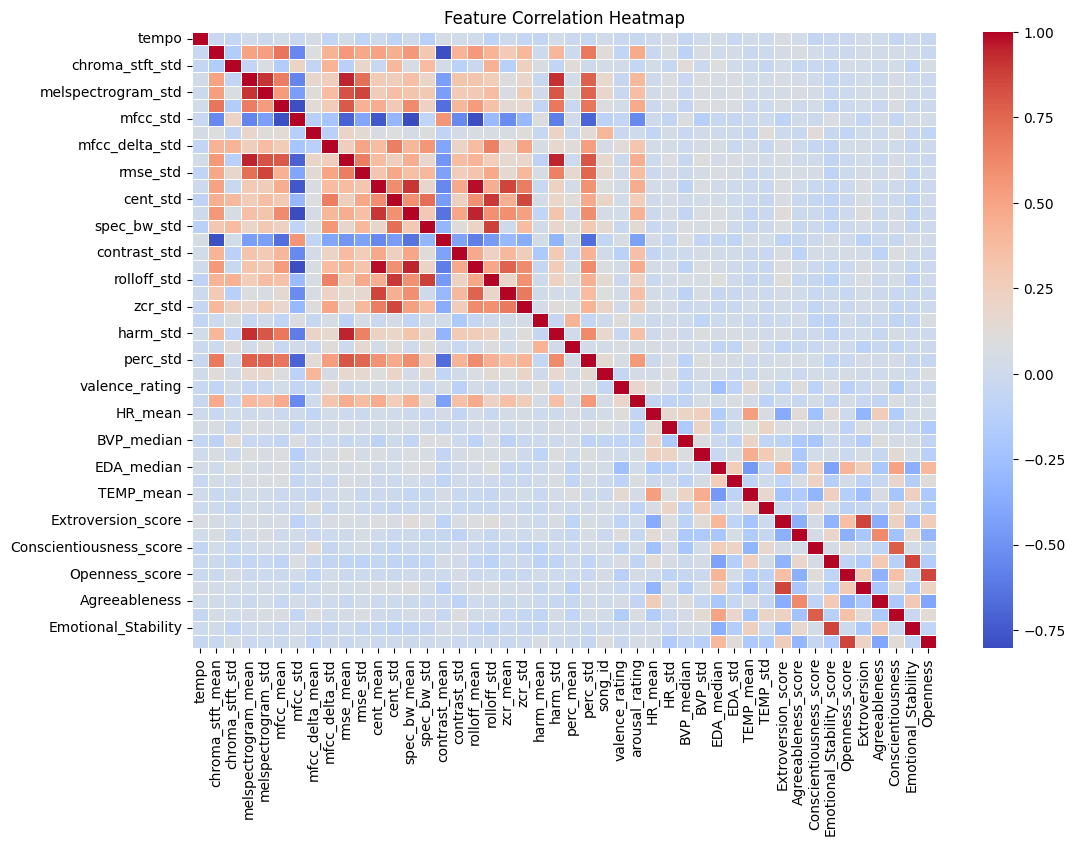

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


###**Feature Distribution Analysis**
Plots histograms for all numerical features in the dataset, showing their distributions.

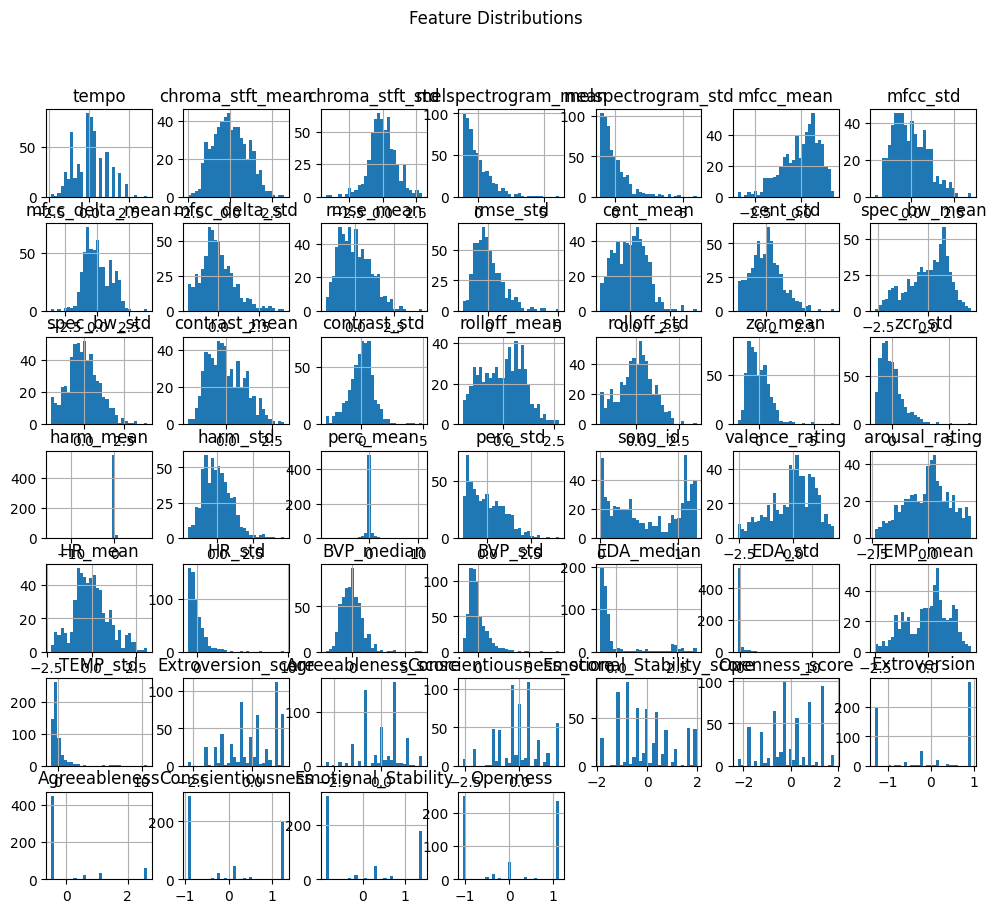

In [ ]:
df.hist(figsize=(12, 10), bins=30)
plt.suptitle("Feature Distributions")
plt.show()

###**Feature Selection**
Identifies and removes highly correlated features by computing the absolute correlation matrix of numerical columns.

In [ ]:
correlation_matrix = df.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find highly correlated features
high_correlation_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.90)]

# Drop highly correlated features
df.drop(columns=high_correlation_features, inplace=True)

print(f"Removed highly correlated features: {high_correlation_features}")


Removed highly correlated features: ['melspectrogram_std', 'rmse_mean', 'spec_bw_mean', 'rolloff_mean', 'harm_std']


###**Feature Importance Chart** using *Random Forest*
- Plots a bar chart of feature importance, ranking features from most to least influential in the model.
- Trains a Random Forest model to determine feature importance based on its predictive power for valence_rating.


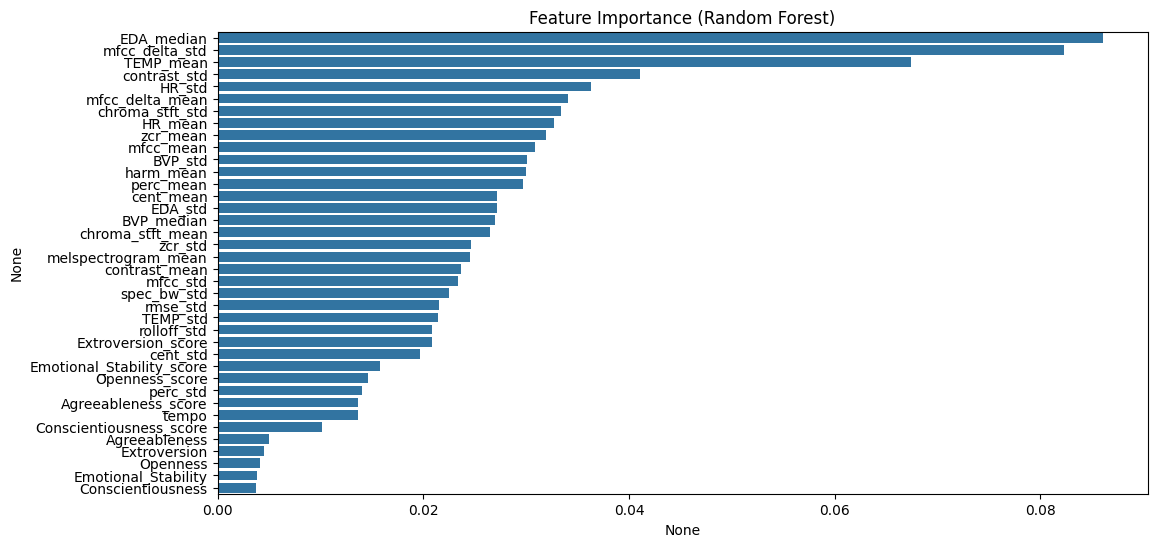

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define X (features) and Y (target variable)
X = df.drop(columns=["song_id", "valence_rating", "arousal_rating"])  # Keep only input features
y = df["valence_rating"]  # Example target (modify as needed)

# Train a model to get feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Sort and plot feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance (Random Forest)")
plt.show()


###**Features Selection** (Threshold-Based)

- Selects important features by filtering out those with an importance score below 0.01, ensuring only relevant features are retained.
- Ensures critical features like "song_id", "valence_rating", "arousal_rating", and key physiological measures remain in the dataset.

In [ ]:
import os

# Define threshold for feature selection
threshold = 0.01  # Drop features below this importance

# Get selected features above the threshold
selected_features = feature_importance[feature_importance > threshold].index.tolist()

# Ensure critical features are retained (No personality features)
essential_features = ["song_id", "valence_rating", "arousal_rating", "EDA_median", "TEMP_mean", "HR_std"]

# Add essential features back if they were removed
for feature in essential_features:
    if feature not in selected_features:
        selected_features.append(feature)

# Drop features below threshold from dataset
features_before = df.shape[1]
df_selected = df[selected_features]
features_after = df_selected.shape[1]
features_dropped = features_before - features_after

print(f"Selected {len(selected_features)} features after filtering.")
print(f"Dropped {features_dropped} low-importance or redundant features.")

# **Ensure the Save Directory Exists**
save_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features"
os.makedirs(save_dir, exist_ok=True)

# **Save the Final Feature-Selected Dataset**
processed_dataset_path = os.path.join(save_dir, "selected_features_dataset.csv")
df_selected.to_csv(processed_dataset_path, index=False)

print(f"Final dataset with selected features saved at: {processed_dataset_path}")


Selected 36 features after filtering.
Dropped 5 low-importance or redundant features.
Final dataset with selected features saved at: /content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/selected_features_dataset.csv


###**Selective Outlier Removal**

- Applies Z-score filtering to remove extreme outliers while ensuring key features such as "valence_rating", "arousal_rating", and personality traits remain untouched.
- Retains essential emotional and physiological features while filtering unnecessary outliers based on a threshold of 3 standard deviations.

In [ ]:
# Load the dataset from Google Drive
dataset_path = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/selected_features_dataset.csv"
df_selected = pd.read_csv(dataset_path)

# Define important features to keep all values (based on literature review)
important_features = [
    "valence_rating", "arousal_rating",  # Emotional target variables
    "EDA_median", "HR_std", "TEMP_mean",  # Physiological responses
    "Openness_score", "Conscientiousness_score", "Extroversion_score",
    "Agreeableness_score", "Emotional_Stability_score"  # Personality scores
]

# Define function to remove outliers using Z-score (while keeping important features)
def remove_outliers_zscore(df, columns, important_features, threshold=3):
    """
    Removes outliers from the dataset based on the Z-score method, while keeping key features untouched.
    :param df: DataFrame containing the data
    :param columns: List of numeric columns to apply outlier removal
    :param important_features: List of features that should NOT be filtered
    :param threshold: Z-score threshold (default=3)
    :return: DataFrame with outliers removed selectively
    """
    df_cleaned = df.copy()
    for col in columns:
        if col in important_features:
            continue  # Skip important features to retain all their values

        mean = df_cleaned[col].mean()
        std = df_cleaned[col].std()
        z_scores = (df_cleaned[col] - mean) / std
        df_cleaned = df_cleaned[(np.abs(z_scores) <= threshold)]  # Keep values within threshold
    return df_cleaned

# Select numeric columns excluding 'song_id'
numeric_columns = df_selected.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_columns.remove("valence_rating")  # Keep target values
numeric_columns.remove("arousal_rating")  # Keep target values

# Apply Z-score outlier removal (but keep important outliers)
df_cleaned_zscore = remove_outliers_zscore(df_selected, numeric_columns, important_features)

# Save cleaned dataset as final_dataset_zscore.csv in Google Drive
save_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/"
os.makedirs(save_dir, exist_ok=True)
final_dataset_path = os.path.join(save_dir, "final_dataset.csv")
df_cleaned_zscore.to_csv(final_dataset_path, index=False)

# Display confirmation message
print(f"Selective Outlier Removal Done. Final dataset saved at: {final_dataset_path}")


Selective Outlier Removal Done. Final dataset saved at: /content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/final_dataset.csv


## **Exploratory Data Analysis (EDA)**

- Detects data issues (missing values, outliers, multicollinearity).
- Identifies important features that contribute to target variables.

####**Summary Statistics**

- Loads the cleaned dataset from Google Drive for further analysis and modeling.
- Displays a statistical summary of numerical features, including count, mean, standard deviation, min, max, and quartiles.

In [ ]:
# Load the cleaned dataset
dataset_path = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/final_dataset.csv"
df_selected = pd.read_csv(dataset_path)

# **Dataset Summary**
print(" Dataset Summary:\n")
print(df_selected.describe())


 Dataset Summary:

       EDA_median  mfcc_delta_std   TEMP_mean  contrast_std      HR_std  \
count  489.000000      489.000000  489.000000    489.000000  489.000000   
mean     0.017640       -0.110235   -0.049672     -0.071747   -0.034942   
std      1.028173        0.856314    0.999746      0.931593    0.949491   
min     -0.627662       -1.793235   -2.492574     -2.896418   -0.948763   
25%     -0.519894       -0.644934   -0.911638     -0.601291   -0.608054   
50%     -0.417224       -0.143861    0.150353      0.043628   -0.281542   
75%     -0.222098        0.452029    0.645155      0.558137    0.188243   
max      3.308808        2.834816    2.023192      2.285143    9.577146   

       mfcc_delta_mean  chroma_stft_std     HR_mean    zcr_mean   mfcc_mean  \
count       489.000000       489.000000  489.000000  489.000000  489.000000   
mean          0.002768        -0.009325   -0.033065   -0.061499   -0.031367   
std           0.969682         0.957098    0.993446    0.829236    0

####**Feature Correlation Heatmap (Conditional on Missing Values)**

- Generates a correlation heatmap only if there are no missing values in the dataset.

- Prevents errors by checking for missing values, ensuring data completeness before plotting.

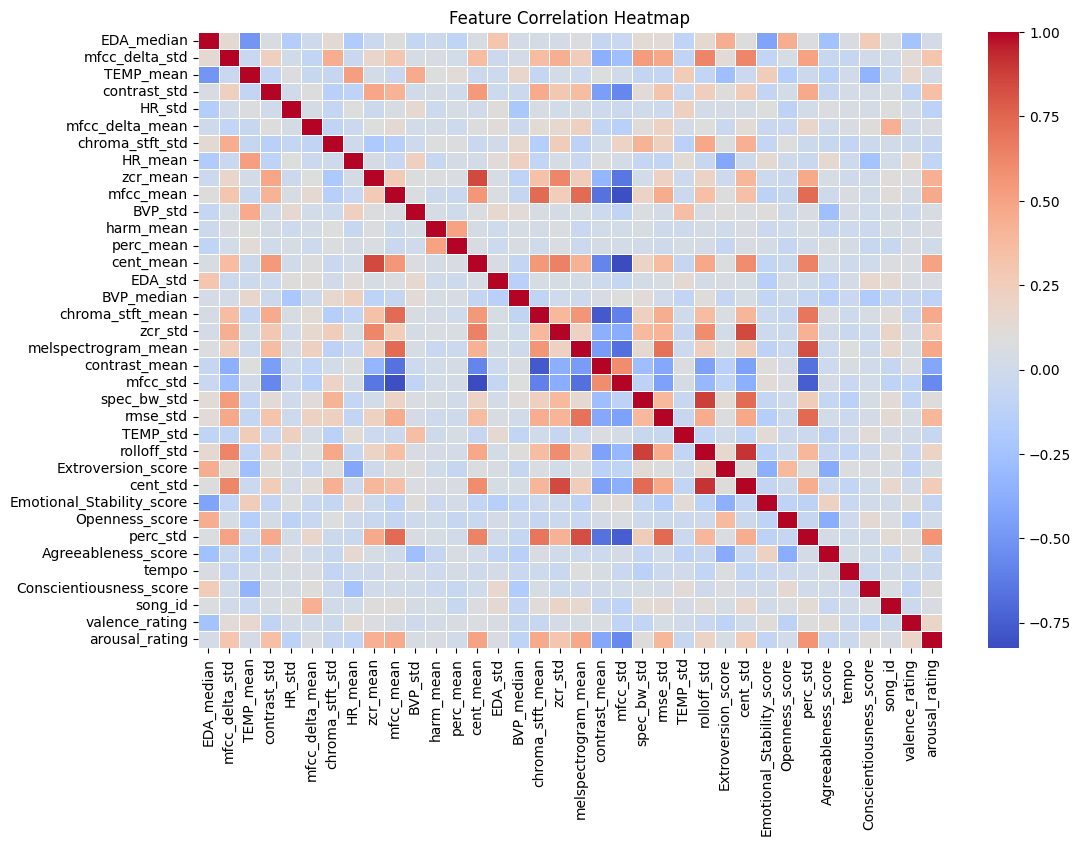

In [ ]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# **Feature Correlation Heatmap (Only If No Missing Values)**
if df_selected.isnull().sum().sum() == 0:  # Ensure no missing values
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_selected.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.show()
else:
    print("Heatmap not generated due to missing values.")


####**Feature Distribution Visualization Using Histograms**

- Generates histograms for all numerical features to visualize their distributions.
- Helps in understanding feature variability, aiding in preprocessing and model training.

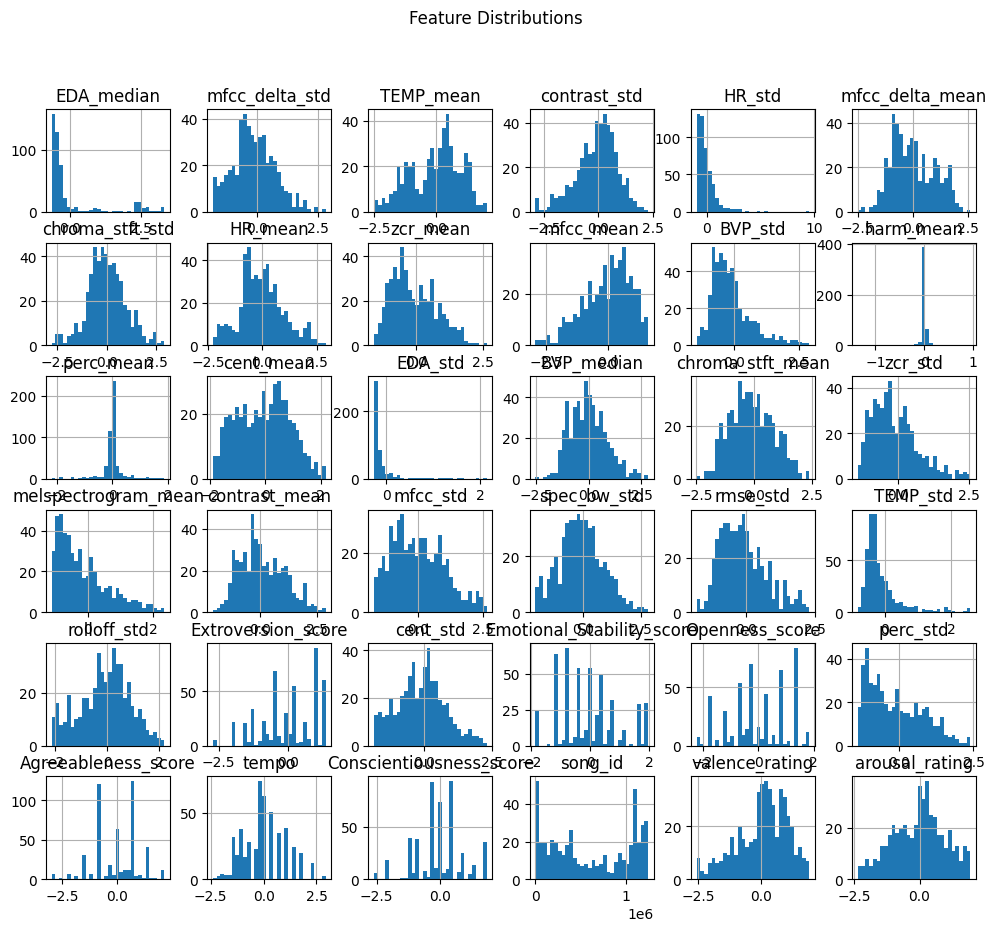

In [ ]:
# Plot histogram for each feature
df_selected.hist(figsize=(12, 10), bins=30)
plt.suptitle("Feature Distributions")
plt.show()


####**Outlier Detection Using Boxplots**
- Boxplot for all numerical features, excluding "song_id", to detect potential outliers.
- Helps identify extreme values that may require further preprocessing, such as removal or transformation.

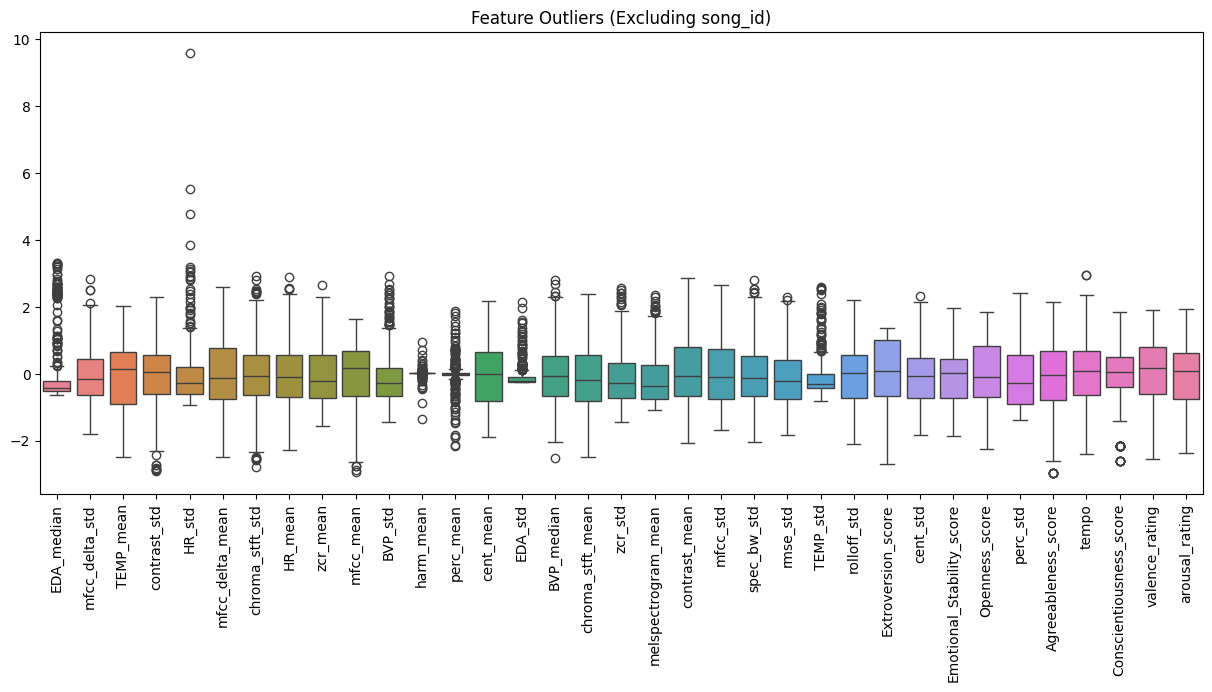

In [ ]:
# Exclude 'song_id' before plotting
df_numeric = df_selected.select_dtypes(include=["float64", "int64"]).drop(columns=["song_id"], errors="ignore")

# Boxplot to detect outliers
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_numeric)
plt.xticks(rotation=90)
plt.title("Feature Outliers (Excluding song_id)")
plt.show()


####**Feature-Target Relationship Analysis Using Scatter Plots**
- Loads the processed dataset and selects key features based on literature review for analysis.
- Generates scatter plots to visualize relationships between key features and valence/arousal ratings.
- Helps assess the strength of correlations, identifying features that may influence emotional responses.

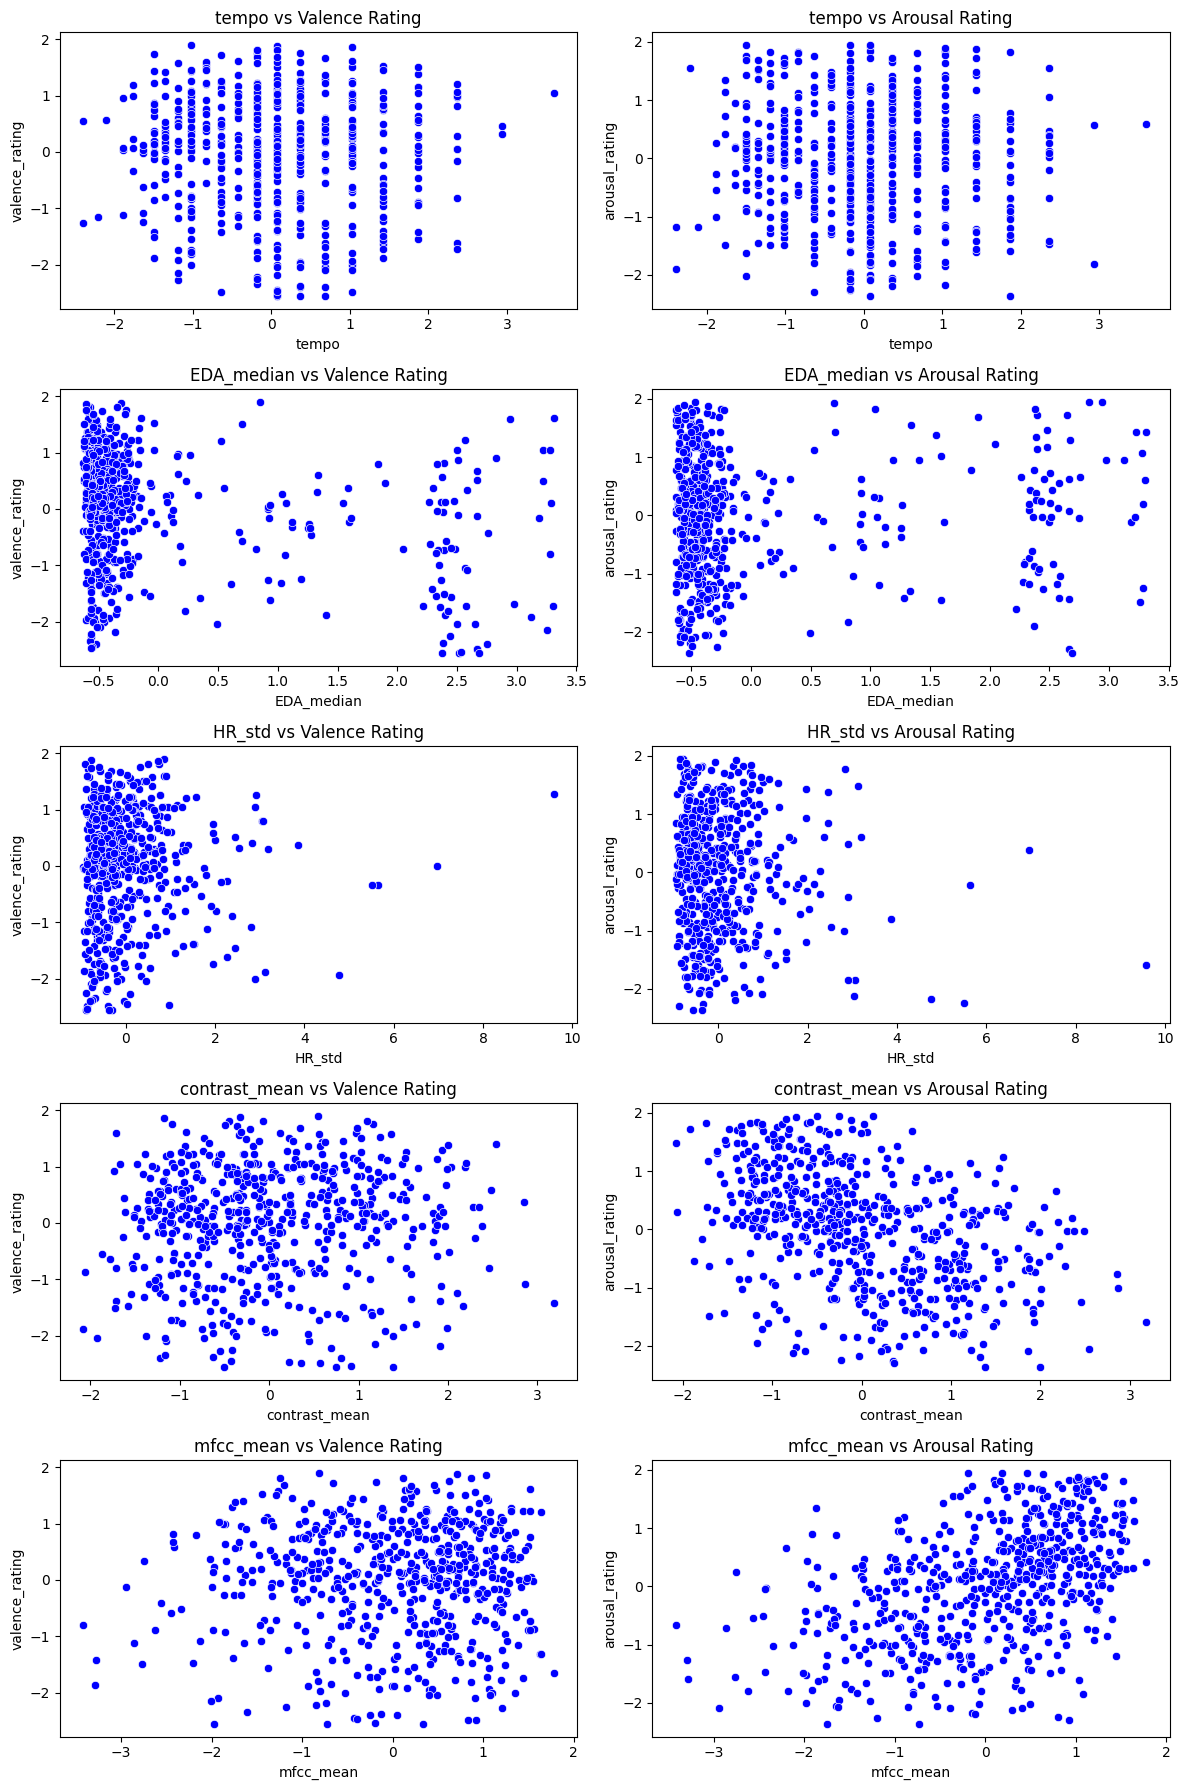

In [ ]:
# Load the processed dataset from Google Drive
dataset_path = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/selected_features_dataset.csv"
df = pd.read_csv(dataset_path)

# Define key features based on literature review
key_features = ["tempo", "EDA_median", "HR_std", "contrast_mean", "mfcc_mean", "rmse_mean"]

# Remove features that do not exist in the dataset
key_features = [feature for feature in key_features if feature in df.columns]

# Generate scatter plots for each key feature against valence and arousal ratings
fig, axes = plt.subplots(len(key_features), 2, figsize=(12, 18))

for i, feature in enumerate(key_features):
    sns.scatterplot(x=df[feature], y=df["valence_rating"], ax=axes[i, 0], color="blue")
    axes[i, 0].set_title(f"{feature} vs Valence Rating")

    sns.scatterplot(x=df[feature], y=df["arousal_rating"], ax=axes[i, 1], color="blue")
    axes[i, 1].set_title(f"{feature} vs Arousal Rating")

plt.tight_layout()
plt.show()


### Dataset Splitting for Model Training

- Loads the processed dataset and separates features (X) from target variables (y_valence, y_arousal).
- Splits data into 70% training, 15% validation, and 15% test sets to ensure proper model evaluation.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the processed dataset
dataset_path = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/selected_features_dataset.csv"
df = pd.read_csv(dataset_path)

# Define features and target variables
X = df.drop(columns=["song_id", "valence_rating", "arousal_rating"])  # Features
y_valence = df["valence_rating"]  # Target 1 (Valence)
y_arousal = df["arousal_rating"]  # Target 2 (Arousal)

# Step 1: Split Data (70% Train, 15% Validation, 15% Test)
X_train, X_temp, y_valence_train, y_valence_temp, y_arousal_train, y_arousal_temp = train_test_split(
    X, y_valence, y_arousal, test_size=0.30, random_state=42
)
X_val, X_test, y_valence_val, y_valence_test, y_arousal_val, y_arousal_test = train_test_split(
    X_temp, y_valence_temp, y_arousal_temp, test_size=0.50, random_state=42
)

# Save the split datasets
save_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Split_Datasets"
import os
os.makedirs(save_dir, exist_ok=True)

# Save datasets
X_train.to_csv(os.path.join(save_dir, "X_train.csv"), index=False)
X_val.to_csv(os.path.join(save_dir, "X_val.csv"), index=False)
X_test.to_csv(os.path.join(save_dir, "X_test.csv"), index=False)

y_valence_train.to_csv(os.path.join(save_dir, "y_valence_train.csv"), index=False)
y_valence_val.to_csv(os.path.join(save_dir, "y_valence_val.csv"), index=False)
y_valence_test.to_csv(os.path.join(save_dir, "y_valence_test.csv"), index=False)

y_arousal_train.to_csv(os.path.join(save_dir, "y_arousal_train.csv"), index=False)
y_arousal_val.to_csv(os.path.join(save_dir, "y_arousal_val.csv"), index=False)
y_arousal_test.to_csv(os.path.join(save_dir, "y_arousal_test.csv"), index=False)

print(f"Dataset Split & Saved at: {save_dir}")


Dataset Split & Saved at: /content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Split_Datasets


###**Model Training, Evaluating, and Testing**

SVM, Random Forest Regression are trained, evaluated and tested as the data has *continuous values*.

####**Training and Evaluating Random Forest & SVM Regression Models**

- Trains both Random Forest and SVM regression models to predict valence and arousal ratings.
- Evaluates models using MAE, MSE, and R² score.

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the split datasets
load_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Split_Datasets"

X_train = pd.read_csv(f"{load_dir}/X_train.csv")
X_val = pd.read_csv(f"{load_dir}/X_val.csv")
X_test = pd.read_csv(f"{load_dir}/X_test.csv")

y_valence_train = pd.read_csv(f"{load_dir}/y_valence_train.csv")
y_valence_val = pd.read_csv(f"{load_dir}/y_valence_val.csv")
y_valence_test = pd.read_csv(f"{load_dir}/y_valence_test.csv")

y_arousal_train = pd.read_csv(f"{load_dir}/y_arousal_train.csv")
y_arousal_val = pd.read_csv(f"{load_dir}/y_arousal_val.csv")
y_arousal_test = pd.read_csv(f"{load_dir}/y_arousal_test.csv")

print("Split Datasets Loaded for Model Training")

# Convert to NumPy arrays for compatibility
y_valence_train, y_valence_val, y_valence_test = (
    y_valence_train.values.ravel(),
    y_valence_val.values.ravel(),
    y_valence_test.values.ravel(),
)

y_arousal_train, y_arousal_val, y_arousal_test = (
    y_arousal_train.values.ravel(),
    y_arousal_val.values.ravel(),
    y_arousal_test.values.ravel(),
)

# ---------------------- Train & Evaluate Random Forest Model ----------------------

print("\nTraining Random Forest Regression Model...")

# Train RF model on Valence
rf_model_valence = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_valence.fit(X_train, y_valence_train)

# Train RF model on Arousal
rf_model_arousal = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_arousal.fit(X_train, y_arousal_train)

# Save Random Forest models
model_save_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Trained_Models/"
os.makedirs(model_save_dir, exist_ok=True)

joblib.dump(rf_model_valence, f"{model_save_dir}/random_forest_valence.pkl")
joblib.dump(rf_model_arousal, f"{model_save_dir}/random_forest_arousal.pkl")

# Predictions
y_valence_pred_rf = rf_model_valence.predict(X_test)
y_arousal_pred_rf = rf_model_arousal.predict(X_test)

# ---------------------- Train & Evaluate SVM Model ----------------------

print("\nTraining SVM Regression Model...")

# Train SVM model on Valence
svm_model_valence = SVR(kernel="rbf")
svm_model_valence.fit(X_train, y_valence_train)

# Train SVM model on Arousal
svm_model_arousal = SVR(kernel="rbf")
svm_model_arousal.fit(X_train, y_arousal_train)

# Save SVM models
joblib.dump(svm_model_valence, f"{model_save_dir}/svm_valence.pkl")
joblib.dump(svm_model_arousal, f"{model_save_dir}/svm_arousal.pkl")

# Predictions
y_valence_pred_svm = svm_model_valence.predict(X_test)
y_arousal_pred_svm = svm_model_arousal.predict(X_test)

# ---------------------- Evaluation ----------------------

def evaluate_model(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "R² Score": r2_score(y_true, y_pred)
    }

# Store evaluation results
results = pd.DataFrame({
    "Model": ["Random Forest", "Random Forest", "SVM", "SVM"],
    "Target": ["Valence", "Arousal", "Valence", "Arousal"],
    "MAE": [
        evaluate_model(y_valence_test, y_valence_pred_rf)["MAE"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf)["MAE"],
        evaluate_model(y_valence_test, y_valence_pred_svm)["MAE"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm)["MAE"]
    ],
    "MSE": [
        evaluate_model(y_valence_test, y_valence_pred_rf)["MSE"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf)["MSE"],
        evaluate_model(y_valence_test, y_valence_pred_svm)["MSE"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm)["MSE"]
    ],
    "R² Score": [
        evaluate_model(y_valence_test, y_valence_pred_rf)["R² Score"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf)["R² Score"],
        evaluate_model(y_valence_test, y_valence_pred_svm)["R² Score"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm)["R² Score"]
    ]
})

# Print results as a table
print("\nModel Evaluation Results:\n")
print(results)

# ---------------------- Save Table as Image ----------------------

import matplotlib.pyplot as plt
import pandas as pd

def save_table_as_image(df, filename):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(cellText=df.round(4).values, colLabels=df.columns, cellLoc="center", loc="center")

    plt.savefig(filename, bbox_inches="tight")
    plt.close()

# Save the results table as an image
results_image_path = f"{model_save_dir}/model_results.png"
save_table_as_image(results, results_image_path)

print(f"\nModel results saved as an image at: {results_image_path}")


Split Datasets Loaded for Model Training

Training Random Forest Regression Model...

Training SVM Regression Model...

Model Evaluation Results:

           Model   Target       MAE       MSE  R² Score
0  Random Forest  Valence  0.696080  0.820186  0.124587
1  Random Forest  Arousal  0.656177  0.657775  0.359951
2            SVM  Valence  0.677905  0.816932  0.128060
3            SVM  Arousal  0.640643  0.635630  0.381500

Model results saved as an image at: /content/drive/MyDrive/Data_Analytics_Coursework/Trained_Models//model_results.png


- Random Forest performed slightly better than SVM for valence (R² = 0.1246 vs. 0.1281) and had similar performance for arousal (R² = 0.3599 vs. 0.3815).
- SVM achieved the highest R² for arousal prediction (0.3815), while Random Forest remained the best overall model due to its balanced performance.

####**Hyperparameter Tuning for Random Forest and SVM**
- Performs Grid Search optimization to find the best hyperparameters for Random Forest and SVM regression models.
- Trains and evaluates optimized models using MAE, MSE, and R² Score on valence and arousal predictions.

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the split datasets
load_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Split_Datasets"

X_train = pd.read_csv(f"{load_dir}/X_train.csv")
X_val = pd.read_csv(f"{load_dir}/X_val.csv")
X_test = pd.read_csv(f"{load_dir}/X_test.csv")

y_valence_train = pd.read_csv(f"{load_dir}/y_valence_train.csv")
y_valence_val = pd.read_csv(f"{load_dir}/y_valence_val.csv")
y_valence_test = pd.read_csv(f"{load_dir}/y_valence_test.csv")

y_arousal_train = pd.read_csv(f"{load_dir}/y_arousal_train.csv")
y_arousal_val = pd.read_csv(f"{load_dir}/y_arousal_val.csv")
y_arousal_test = pd.read_csv(f"{load_dir}/y_arousal_test.csv")

print("Split Datasets Loaded for Hyperparameter Tuning")

# Convert to NumPy arrays
y_valence_train, y_valence_val, y_valence_test = (
    y_valence_train.values.ravel(),
    y_valence_val.values.ravel(),
    y_valence_test.values.ravel(),
)

y_arousal_train, y_arousal_val, y_arousal_test = (
    y_arousal_train.values.ravel(),
    y_arousal_val.values.ravel(),
    y_arousal_test.values.ravel(),
)

# ---------------------- Hyperparameter Tuning for Random Forest ----------------------

print("\nTuning Random Forest Regression Model...")

# Define RF hyperparameter grid
rf_param_grid = {
    "n_estimators": [100, 300, 500],  # Number of trees
    "max_depth": [10, 20, None],  # Tree depth
    "min_samples_split": [2, 5, 10],  # Min samples to split a node
}

# Perform Grid Search for Valence
rf_grid_valence = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, scoring="r2", n_jobs=-1)
rf_grid_valence.fit(X_train, y_valence_train)
best_rf_valence = rf_grid_valence.best_estimator_

# Perform Grid Search for Arousal
rf_grid_arousal = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, scoring="r2", n_jobs=-1)
rf_grid_arousal.fit(X_train, y_arousal_train)
best_rf_arousal = rf_grid_arousal.best_estimator_

print(f"Best RF Parameters (Valence): {rf_grid_valence.best_params_}")
print(f"Best RF Parameters (Arousal): {rf_grid_arousal.best_params_}")

# ---------------------- Hyperparameter Tuning for SVM ----------------------

print("\nTuning SVM Regression Model...")

# Define SVM hyperparameter grid
svm_param_grid = {
    "kernel": ["linear", "rbf", "poly"],  # Kernel types
    "C": [0.1, 1, 10],  # Regularization parameter
    "gamma": ["scale", "auto"],  # Kernel coefficient
}

# Perform Grid Search for Valence
svm_grid_valence = GridSearchCV(SVR(), svm_param_grid, cv=3, scoring="r2", n_jobs=-1)
svm_grid_valence.fit(X_train, y_valence_train)
best_svm_valence = svm_grid_valence.best_estimator_

# Perform Grid Search for Arousal
svm_grid_arousal = GridSearchCV(SVR(), svm_param_grid, cv=3, scoring="r2", n_jobs=-1)
svm_grid_arousal.fit(X_train, y_arousal_train)
best_svm_arousal = svm_grid_arousal.best_estimator_

print(f"Best SVM Parameters (Valence): {svm_grid_valence.best_params_}")
print(f"Best SVM Parameters (Arousal): {svm_grid_arousal.best_params_}")

# ---------------------- Save Optimized Models ----------------------

model_save_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Trained_Models/"
os.makedirs(model_save_dir, exist_ok=True)

joblib.dump(best_rf_valence, f"{model_save_dir}/optimized_rf_valence.pkl")
joblib.dump(best_rf_arousal, f"{model_save_dir}/optimized_rf_arousal.pkl")
joblib.dump(best_svm_valence, f"{model_save_dir}/optimized_svm_valence.pkl")
joblib.dump(best_svm_arousal, f"{model_save_dir}/optimized_svm_arousal.pkl")

print("\nOptimized Models Saved.")

# ---------------------- Evaluate Optimized Models ----------------------

def evaluate_model(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "R² Score": r2_score(y_true, y_pred)
    }

# Predict using optimized models
y_valence_pred_rf_best = best_rf_valence.predict(X_test)
y_arousal_pred_rf_best = best_rf_arousal.predict(X_test)

y_valence_pred_svm_best = best_svm_valence.predict(X_test)
y_arousal_pred_svm_best = best_svm_arousal.predict(X_test)

# Store evaluation results
results = pd.DataFrame({
    "Model": ["Optimized RF", "Optimized RF", "Optimized SVM", "Optimized SVM"],
    "Target": ["Valence", "Arousal", "Valence", "Arousal"],
    "MAE": [
        evaluate_model(y_valence_test, y_valence_pred_rf_best)["MAE"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf_best)["MAE"],
        evaluate_model(y_valence_test, y_valence_pred_svm_best)["MAE"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm_best)["MAE"]
    ],
    "MSE": [
        evaluate_model(y_valence_test, y_valence_pred_rf_best)["MSE"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf_best)["MSE"],
        evaluate_model(y_valence_test, y_valence_pred_svm_best)["MSE"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm_best)["MSE"]
    ],
    "R² Score": [
        evaluate_model(y_valence_test, y_valence_pred_rf_best)["R² Score"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf_best)["R² Score"],
        evaluate_model(y_valence_test, y_valence_pred_svm_best)["R² Score"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm_best)["R² Score"]
    ]
})

# Print results as a table
print("\nOptimized Model Evaluation Results:\n")
print(results)

# ---------------------- Save Table as Image ----------------------

def save_table_as_image(df, filename):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(cellText=df.round(4).values, colLabels=df.columns, cellLoc="center", loc="center")

    plt.savefig(filename, bbox_inches="tight")
    plt.close()

# Save the results table as an image
results_image_path = f"{model_save_dir}/optimized_model_results.png"
save_table_as_image(results, results_image_path)

print(f"\nOptimized model results saved as an image at: {results_image_path}")


Split Datasets Loaded for Hyperparameter Tuning

Tuning Random Forest Regression Model...
Best RF Parameters (Valence): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best RF Parameters (Arousal): {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}

Tuning SVM Regression Model...
Best SVM Parameters (Valence): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM Parameters (Arousal): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Optimized Models Saved.

Optimized Model Evaluation Results:

           Model   Target       MAE       MSE  R² Score
0   Optimized RF  Valence  0.698451  0.811157  0.134224
1   Optimized RF  Arousal  0.653220  0.643093  0.374238
2  Optimized SVM  Valence  0.677905  0.816932  0.128060
3  Optimized SVM  Arousal  0.640643  0.635630  0.381500

Optimized model results saved as an image at: /content/drive/MyDrive/Data_Analytics_Coursework/Trained_Models//optimized_model_results.png


- Hyperparameter tuning improved Random Forest performance, especially for arousal (R² = 0.3742), making it more competitive with SVM.
- SVM remained the best for arousal prediction (R² = 0.3815), while Optimized RF achieved the highest R² for valence (0.1342), confirming its stability.

###**Model Training on Interaction Features**

*Improves Model Predictive Power*

- Interaction terms help machine learning models (especially linear models) capture complex dependencies between features.

Example: MFCC and spectral contrast together may better capture music dynamics than individually.

####**Interaction Features for Model Training** (further optimization - referenced)

- Generates new interaction features (tempo_x_EDA, contrast_x_mfcc, HR_std_x_EDA, mfcc_x_rms) by multiplying related feature pairs following *the literature review*.

- Ensures only existing features are used, avoiding errors if some columns are missing.
Saves the updated datasets with interaction features for further model training and evaluation.

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np


# Load the split datasets
load_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Split_Datasets"

X_train = pd.read_csv(f"{load_dir}/X_train.csv")
X_val = pd.read_csv(f"{load_dir}/X_val.csv")
X_test = pd.read_csv(f"{load_dir}/X_test.csv")

# ---------------------- Create Interaction Features ----------------------

# Define interaction features based on available columns
interaction_pairs = {
    "tempo_x_EDA": ["tempo", "EDA_median"],
    "contrast_x_mfcc": ["contrast_mean", "mfcc_mean"],
    "HR_std_x_EDA": ["HR_std", "EDA_median"],
    "mfcc_x_rms": ["mfcc_mean", "rmse_std"]  # Changed from 'rmse_mean' to 'rmse_std'
}

# Apply interaction features only if both features exist
for new_feature, (col1, col2) in interaction_pairs.items():
    if col1 in X_train.columns and col2 in X_train.columns:
        X_train[new_feature] = X_train[col1] * X_train[col2]
        X_val[new_feature] = X_val[col1] * X_val[col2]
        X_test[new_feature] = X_test[col1] * X_test[col2]
    else:
        print(f"Skipping {new_feature} - One or both features missing: {col1}, {col2}")

# ---------------------- Save Updated Datasets ----------------------

# Save the new datasets with interaction features
save_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Interactions_Split/"
os.makedirs(save_dir, exist_ok=True)

X_train.to_csv(os.path.join(save_dir, "X_train_interactions.csv"), index=False)
X_val.to_csv(os.path.join(save_dir, "X_val_interactions.csv"), index=False)
X_test.to_csv(os.path.join(save_dir, "X_test_interactions.csv"), index=False)

print(f" Updated datasets with interaction features saved at: {save_dir}")


 Updated datasets with interaction features saved at: /content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Interactions_Split/


####**Training and Evaluating Random Forest & SVM with Interaction Features**

- Loads datasets with newly engineered interaction features and trains Random Forest (RF) and Support Vector Regression (SVR) models.
- Evaluates model performance using MAE, MSE, and R² score, comparing predictions for valence and arousal.





In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load the updated datasets with interaction features
load_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Interactions_Split/"

X_train = pd.read_csv(f"{load_dir}/X_train_interactions.csv")
X_val = pd.read_csv(f"{load_dir}/X_val_interactions.csv")
X_test = pd.read_csv(f"{load_dir}/X_test_interactions.csv")

# Load original target variables
target_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Split_Datasets/"

y_valence_train = pd.read_csv(f"{target_dir}/y_valence_train.csv").values.ravel()
y_valence_val = pd.read_csv(f"{target_dir}/y_valence_val.csv").values.ravel()
y_valence_test = pd.read_csv(f"{target_dir}/y_valence_test.csv").values.ravel()

y_arousal_train = pd.read_csv(f"{target_dir}/y_arousal_train.csv").values.ravel()
y_arousal_val = pd.read_csv(f"{target_dir}/y_arousal_val.csv").values.ravel()
y_arousal_test = pd.read_csv(f"{target_dir}/y_arousal_test.csv").values.ravel()

print(" Split Datasets with Interaction Features Loaded for Model Training")

# ---------------------- Train & Evaluate Random Forest Model ----------------------

print("\n Training Random Forest Regression Model...")

# Train RF model on Valence
rf_model_valence = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
rf_model_valence.fit(X_train, y_valence_train)

# Train RF model on Arousal
rf_model_arousal = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
rf_model_arousal.fit(X_train, y_arousal_train)

# Save RF models
model_save_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Trained_Models/With_Interactions/"
os.makedirs(model_save_dir, exist_ok=True)

joblib.dump(rf_model_valence, f"{model_save_dir}/rf_valence_interactions.pkl")
joblib.dump(rf_model_arousal, f"{model_save_dir}/rf_arousal_interactions.pkl")

# Predictions
y_valence_pred_rf = rf_model_valence.predict(X_test)
y_arousal_pred_rf = rf_model_arousal.predict(X_test)

# ---------------------- Train & Evaluate SVM Model ----------------------

print("\n Training SVM Regression Model...")

# Train SVM model on Valence
svm_model_valence = SVR(kernel="rbf", C=10, gamma="scale")
svm_model_valence.fit(X_train, y_valence_train)

# Train SVM model on Arousal
svm_model_arousal = SVR(kernel="rbf", C=10, gamma="scale")
svm_model_arousal.fit(X_train, y_arousal_train)

# Save SVM models
joblib.dump(svm_model_valence, f"{model_save_dir}/svm_valence_interactions.pkl")
joblib.dump(svm_model_arousal, f"{model_save_dir}/svm_arousal_interactions.pkl")

# Predictions
y_valence_pred_svm = svm_model_valence.predict(X_test)
y_arousal_pred_svm = svm_model_arousal.predict(X_test)

# ---------------------- Evaluation ----------------------

def evaluate_model(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "R² Score": r2_score(y_true, y_pred)
    }

# Store evaluation results
results = pd.DataFrame({
    "Model": ["RF with Interactions", "RF with Interactions", "SVM with Interactions", "SVM with Interactions"],
    "Target": ["Valence", "Arousal", "Valence", "Arousal"],
    "MAE": [
        evaluate_model(y_valence_test, y_valence_pred_rf)["MAE"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf)["MAE"],
        evaluate_model(y_valence_test, y_valence_pred_svm)["MAE"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm)["MAE"]
    ],
    "MSE": [
        evaluate_model(y_valence_test, y_valence_pred_rf)["MSE"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf)["MSE"],
        evaluate_model(y_valence_test, y_valence_pred_svm)["MSE"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm)["MSE"]
    ],
    "R² Score": [
        evaluate_model(y_valence_test, y_valence_pred_rf)["R² Score"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf)["R² Score"],
        evaluate_model(y_valence_test, y_valence_pred_svm)["R² Score"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm)["R² Score"]
    ]
})

# Print results as a table
print("\nModel Evaluation Results with Interaction Features:\n")
print(results)

# ---------------------- Save Table as Image ----------------------

def save_table_as_image(df, filename):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(cellText=df.round(4).values, colLabels=df.columns, cellLoc="center", loc="center")

    plt.savefig(filename, bbox_inches="tight")
    plt.close()

# Save the results table as an image
results_image_path = f"{model_save_dir}/interaction_model_results.png"
save_table_as_image(results, results_image_path)

print(f"\nOptimized model results with interactions saved at: {results_image_path}")


 Split Datasets with Interaction Features Loaded for Model Training

 Training Random Forest Regression Model...

 Training SVM Regression Model...

Model Evaluation Results with Interaction Features:

                   Model   Target       MAE       MSE  R² Score
0   RF with Interactions  Valence  0.703967  0.808659  0.136890
1   RF with Interactions  Arousal  0.651990  0.644391  0.372974
2  SVM with Interactions  Valence  0.735070  0.905485  0.033544
3  SVM with Interactions  Arousal  0.716313  0.786478  0.234716

Optimized model results with interactions saved at: /content/drive/MyDrive/Data_Analytics_Coursework/Trained_Models/With_Interactions//interaction_model_results.png


- Random Forest with interaction features performed slightly better in valence (R² = 0.1369) and arousal (R² = 0.3729), showing a small improvement.
- SVM performed worse on valence (R² = 0.0335) and dropped in arousal (R² = 0.2347), indicating that interaction features did not benefit SVM.

####Refining Interaction Features by Removing Low-Impact Terms

- Loads datasets with interaction features and removes low-impact interactions (contrast_x_mfcc, mfcc_x_rms) based on previous model performance.
- Ensures only meaningful interaction features remain, improving model efficiency by reducing unnecessary complexity.

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np

# Load the split datasets with interactions
load_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Interactions_Split/"

X_train = pd.read_csv(f"{load_dir}/X_train_interactions.csv")
X_val = pd.read_csv(f"{load_dir}/X_val_interactions.csv")
X_test = pd.read_csv(f"{load_dir}/X_test_interactions.csv")

# ---------------------- Remove Low-Impact Interaction Features ----------------------

# Define interaction features to remove based on previous results
features_to_remove = ["contrast_x_mfcc", "mfcc_x_rms"]

# Drop these features if they exist in the dataset
X_train = X_train.drop(columns=[col for col in features_to_remove if col in X_train.columns], errors="ignore")
X_val = X_val.drop(columns=[col for col in features_to_remove if col in X_val.columns], errors="ignore")
X_test = X_test.drop(columns=[col for col in features_to_remove if col in X_test.columns], errors="ignore")

# ---------------------- Save Updated Datasets ----------------------

# Save the new datasets with only meaningful interaction features
save_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Refined_Interactions/"
os.makedirs(save_dir, exist_ok=True)

X_train.to_csv(os.path.join(save_dir, "X_train_refined.csv"), index=False)
X_val.to_csv(os.path.join(save_dir, "X_val_refined.csv"), index=False)
X_test.to_csv(os.path.join(save_dir, "X_test_refined.csv"), index=False)

print(f"Updated datasets with refined interaction features saved at: {save_dir}")


Updated datasets with refined interaction features saved at: /content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Refined_Interactions/


#### **Training and Evaluating Random Forest & SVM with Refined Interaction Features**
- Loads datasets with refined interaction features and trains Random Forest (RF) and Support Vector Regression (SVR) models.
- Evaluates model performance using MAE, MSE, and R² score, assessing valence and arousal prediction accuracy.

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the refined datasets with interaction features
load_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Refined_Interactions/"

X_train = pd.read_csv(f"{load_dir}/X_train_refined.csv")
X_val = pd.read_csv(f"{load_dir}/X_val_refined.csv")
X_test = pd.read_csv(f"{load_dir}/X_test_refined.csv")

# Load original target variables
target_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Processed_Dataset_Features/Split_Datasets/"

y_valence_train = pd.read_csv(f"{target_dir}/y_valence_train.csv").values.ravel()
y_valence_val = pd.read_csv(f"{target_dir}/y_valence_val.csv").values.ravel()
y_valence_test = pd.read_csv(f"{target_dir}/y_valence_test.csv").values.ravel()

y_arousal_train = pd.read_csv(f"{target_dir}/y_arousal_train.csv").values.ravel()
y_arousal_val = pd.read_csv(f"{target_dir}/y_arousal_val.csv").values.ravel()
y_arousal_test = pd.read_csv(f"{target_dir}/y_arousal_test.csv").values.ravel()

print(" Split Datasets with Refined Interaction Features Loaded for Model Training")

# ---------------------- Train & Evaluate Random Forest Model ----------------------

print("\n Training Random Forest Regression Model...")

# Train RF model on Valence
rf_model_valence = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
rf_model_valence.fit(X_train, y_valence_train)

# Train RF model on Arousal
rf_model_arousal = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
rf_model_arousal.fit(X_train, y_arousal_train)

# Save RF models
model_save_dir = "/content/drive/MyDrive/Data_Analytics_Coursework/Trained_Models/Refined_Interactions/"
os.makedirs(model_save_dir, exist_ok=True)

joblib.dump(rf_model_valence, f"{model_save_dir}/rf_valence_refined.pkl")
joblib.dump(rf_model_arousal, f"{model_save_dir}/rf_arousal_refined.pkl")

# Predictions
y_valence_pred_rf = rf_model_valence.predict(X_test)
y_arousal_pred_rf = rf_model_arousal.predict(X_test)

# ---------------------- Train & Evaluate SVM Model ----------------------

print("\n Training SVM Regression Model...")

# Train SVM model on Valence
svm_model_valence = SVR(kernel="rbf", C=10, gamma="scale")
svm_model_valence.fit(X_train, y_valence_train)

# Train SVM model on Arousal
svm_model_arousal = SVR(kernel="rbf", C=10, gamma="scale")
svm_model_arousal.fit(X_train, y_arousal_train)

# Save SVM models
joblib.dump(svm_model_valence, f"{model_save_dir}/svm_valence_refined.pkl")
joblib.dump(svm_model_arousal, f"{model_save_dir}/svm_arousal_refined.pkl")

# Predictions
y_valence_pred_svm = svm_model_valence.predict(X_test)
y_arousal_pred_svm = svm_model_arousal.predict(X_test)

# ---------------------- Evaluation ----------------------

def evaluate_model(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "R² Score": r2_score(y_true, y_pred)
    }

# Store evaluation results
results = pd.DataFrame({
    "Model": ["RF with Refined Features", "RF with Refined Features", "SVM with Refined Features", "SVM with Refined Features"],
    "Target": ["Valence", "Arousal", "Valence", "Arousal"],
    "MAE": [
        evaluate_model(y_valence_test, y_valence_pred_rf)["MAE"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf)["MAE"],
        evaluate_model(y_valence_test, y_valence_pred_svm)["MAE"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm)["MAE"]
    ],
    "MSE": [
        evaluate_model(y_valence_test, y_valence_pred_rf)["MSE"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf)["MSE"],
        evaluate_model(y_valence_test, y_valence_pred_svm)["MSE"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm)["MSE"]
    ],
    "R² Score": [
        evaluate_model(y_valence_test, y_valence_pred_rf)["R² Score"],
        evaluate_model(y_arousal_test, y_arousal_pred_rf)["R² Score"],
        evaluate_model(y_valence_test, y_valence_pred_svm)["R² Score"],
        evaluate_model(y_arousal_test, y_arousal_pred_svm)["R² Score"]
    ]
})

# Print results as a table
print("\nModel Evaluation Results with Refined Interaction Features:\n")
print(results)

# ---------------------- Save Table as Image ----------------------

def save_table_as_image(df, filename):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(cellText=df.round(4).values, colLabels=df.columns, cellLoc="center", loc="center")

    plt.savefig(filename, bbox_inches="tight")
    plt.close()

# Save the results table as an image
results_image_path = f"{model_save_dir}/refined_interaction_model_results.png"
save_table_as_image(results, results_image_path)

print(f"\nOptimized model results with refined interactions saved at: {results_image_path}")


 Split Datasets with Refined Interaction Features Loaded for Model Training

 Training Random Forest Regression Model...

 Training SVM Regression Model...

Model Evaluation Results with Refined Interaction Features:

                       Model   Target       MAE       MSE  R² Score
0   RF with Refined Features  Valence  0.712675  0.830063  0.114045
1   RF with Refined Features  Arousal  0.649926  0.647723  0.369732
2  SVM with Refined Features  Valence  0.719585  0.900172  0.039215
3  SVM with Refined Features  Arousal  0.696848  0.757534  0.262881

Optimized model results with refined interactions saved at: /content/drive/MyDrive/Data_Analytics_Coursework/Trained_Models/Refined_Interactions//refined_interaction_model_results.png


##Dataset Links

Hu, Xiao; Li, Fanjie; Liu, Ruilun (2022). HKU956: Dataset in "Detecting Music-Induced Emotion Based on Acoustic Analysis and Physiological Sensing: A Multimodal Approach". HKU Data Repository. Dataset.

link: https://doi.org/10.25442/hku.21080821.v4https://doi.org/10.25442/hku.21080821.v4


##**Author Details:**
Name: Rohan Naveen Murala

Student ID: 240151478

Course Name: Data Analytics ECS784P

University Name: Queen Mary University of London

find this study on: https://github.com/rohanmurala/Music-Induced-Emotion-Prediction-A-Regression-Based-Analysis-of-Physiological-and-Acoustic-Data.git